In [2]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
# Gerardo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn import preprocessing
pd.set_option('display.max_columns', None)

## Introducción

En este notebook se estudia la posibilidad de utilizar el clasificador KNN en nuestro dataset acompañado previamente (o no) de una reducción dimensional de los datos aplicando PCA.

Las pruebas que se van a realizar son las siguientes:
* KNN sin reducir dimensiones
* KNN con PCA

## Importamos el dataset

In [3]:
data = pd.read_csv("../data-sets/philippine-income.csv")

# Categorizamos la variable income 

def inc_groups(series):
    if series < 35000:
        return "Bajo"
    elif 35000 <= series < 700000:
        return "Medio"
    elif 700000 <= series:
        return "Alto"

data['T.H.I'] = data['T.H.I'].apply(inc_groups)

data['T.H.I'].value_counts(sort=False)

data.head()


T.H.I   T.F.E   Tobacco  I.H.R.V  MCareExp  Tra.Exp  G.F.G.E  H.H.Age  \
0   Alto  204969    Smoker    90000      3469    50448        0       42   
1  Medio   50545    Smoker     4500       470     2100        0       40   
2  Medio   74240  NoSmoker    90000       545     4032        0       76   
3  Medio   57793    Smoker     7200      2320     2676        0       54   
4  Medio   87578  NoSmoker        0       240    39960        0       35   

   Floor.Area  House.Age    PPN    CYP      GL     BYS            RTvsNT  \
0          24         25  52769  64422  116090  314680  33,3333333333333   
1          50         14  37504  11695    1470   33572                 0   
2          77         20  52697  14935   14420  137586                50   
3          40         18  40016  14763    5115   25505                 0   
4          45         10  24785   7518   56861  164540               100   

  Bedrooms      TV CD.VCD.DVD ComponentStereoSet RefrigeratorFreezer  \
0     Many  Unique       None               None              Unique   
1     None    None       None               None                None   
2     Many  Unique       None               None              Unique   
3   Unique  Unique     Unique             Unique                None   
4     Many  Unique       None             Unique              Unique   

  WashingMachine Airconditioner Motorvehicle LandlineWirelessTelephones  \
0         Unique         Unique       Unique                     Unique   
1           None           None         None                       None   
2           None         Unique         None                       None   
3           None           None         None                       None   
4           None           None         None                       None   

  CellularPhone PersonalComputers StoveWithOvenGasRange MotorizedBanca  \
0          Many              Many                  None           None   
1        Unique              None                  None           None   
2        Unique              None                  None           None   
3        Unique              None                  None         Unique   
4          Many            Unique                  None           None   

  MotorcycleTricycle            Region       Main.Source.of.Income  \
0               None               NCR               Wage/Salaries   
1               None              ARMM  Enterpreneurial Activities   
2               None            Caraga     Other sources of Income   
3               None  V - Bicol Region  Enterpreneurial Activities   
4               None               NCR               Wage/Salaries   

  Household.Head.Sex Household.Head.Marital.Status  \
0               Male                       Married   
1               Male                       Married   
2             Female                       Widowed   
3               Male                       Married   
4               Male                       Married   

  Household.Head.Job.or.Business.Indicator Electricity  \
0                        With Job/Business          Si   
1                        With Job/Business          Si   
2                          No Job/Business          Si   
3                        With Job/Business          Si   
4                        With Job/Business          Si   

                Young.Members    Roof   TenueStatus    TypeHousehold  \
0  between 5 and 17 years old  Strong    Fully_Paid  Extended Family   
1  between 5 and 17 years old   Light    Fully_Paid    Single Family   
2                 No children  Strong    Fully_Paid    Single Family   
3  between 5 and 17 years old   Light  Partial_Paid  Extended Family   
4                 No children  Strong    Fully_Paid  Extended Family   

          Worker            TypeBuilding   Walls Toilet            Water  
0      Freelance            Single house  Strong   Good  Good conditions  
1      Freelance            Single house   Light   Poor  Good conditions  
2  Civi

In [4]:
print('Se muestran cuántas muestras hay de cada cada categoría:\n',data.groupby('T.H.I').size())

Se muestran cuántas muestras hay de cada cada categoría:
 T.H.I
Alto      363
Bajo       76
Medio    6562
dtype: int64


## División en Train y Test

In [5]:
# Definimos nuestra variable target

y = data[['T.H.I']]
X = data.drop('T.H.I', axis = 1)
#print(y.head())
#print(X.head())

# Dividimos nuestro dataset en train y test al 80% y 20% asegurando que se mantienen las proporciones entre las
# distintas clases
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.30,random_state =1,stratify=y)

print('Distribución de las clases en las muestras de entrenamiento:\n',yTrain.groupby('T.H.I').size())
print('Distribución de las clases en las muestras de test:\n',yTest.groupby('T.H.I').size())

# Extraemos solo las variables numéricas de nuestro xTrain y xTest

xtrainnum = xTrain.select_dtypes('number')
xtestnum = xTest.select_dtypes('number')

Distribución de las clases en las muestras de entrenamiento:
 T.H.I
Alto      254
Bajo       53
Medio    4593
dtype: int64
Distribución de las clases en las muestras de test:
 T.H.I
Alto      109
Bajo       23
Medio    1969
dtype: int64


## PCA como método de reducción de dimensionalidad

In [6]:
# Probar 0.60
pca = PCA(n_components=2,svd_solver='full')

## Modelo KNN para clasificación

Este modelo es supervisado y en nuestro caso en particular será usado como un problema de regresión. Recordemos que aplicar un KNN a nuestra variable target (Income) nos dará nuevos data poins en función a los k números de los data points más cercanos

es importante tener en cuenta que nuestra variable target es numérica, por lo que a la hora de aplicar un KNN tenemos que preparar PREVIAMENTE LOS DATOS. podemos optar por dos caminos:

* Añadir un porcentage de error a cada uno de los datos. de tal forma que si nuestro modelo falla por cuestion de uno o dos puntos (e.g predice que el income será de 20001 en vez de 20000 pesos filipinos) no bajará su accuracy.

* Clasificar nuestra variable target en tres clases

en este caso, hemos optado por el segundo escenario

Antes de aplicar KNN podemos optar por normalizar o no nuestros datos. Aquí se prueban los siguientes casos:

* Sin normalizar ni estandarizar (normalizar: u=u, sigma=0, estandarizar: u=1, sigma=0)
* Normalizando los datos
* Estandarizando los datos

## Sin normalizar ni estandarizar los datos y aplicando reducción

In [7]:
# Probar a reducir a 2 componentes y hacer un scatter plot

sample_train_pca_ger = pca.fit_transform(xtrainnum)
sample_test_pca_ger = pca.transform(xtestnum)

print('Porcentaje de la varianza explicada: \t',pca.explained_variance_ratio_)
#print(pca.explained_variance_)
print('Coordenadas de las componentes principales: \n',pca.components_)
print('Autovalores asociados a las componentes: \t',pca.singular_values_)
#print(pca.noise_variance_)

Porcentaje de la varianza explicada: 	 [0.64165135 0.13966756]
Coordenadas de las componentes principales: 
 [[ 3.96173128e-01  3.54084361e-01  7.32634904e-02  1.11175574e-01
  -1.18876176e-02  7.33591370e-06  2.53218947e-04  2.10318479e-05
   9.90014801e-02  1.04576623e-01  2.42950837e-01  7.87425881e-01]
 [-6.94350129e-01  4.44161281e-01 -1.57993843e-02 -7.83715890e-02
  -6.50687737e-02  2.93886774e-05  1.24359698e-04  3.32585726e-06
  -2.94792231e-01 -1.57677976e-01 -3.13661095e-01  3.15950756e-01]]
Autovalores asociados a las componentes: 	 [6988227.94445195 3260357.93744037]


In [13]:
import warnings
warnings.filterwarnings('ignore')

# Gerardo - KNN
neig_k = np.arange(1, 23, 2)
scores = []
for k in neig_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(sample_train_pca_ger, yTrain)
    predictions_KNN = knn.predict(sample_test_pca_ger)
    scores.append(metrics.accuracy_score(yTest, predictions_KNN))
print('El valor máximo de accuracy se consigue para un k de : ', neig_k[scores.index(max(scores))],
      'con un valor de', max(scores))

print('Valores de accuracy:\n', scores)
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(sample_train_pca_ger, yTrain)
predictions_KNN = knn.predict(sample_test_pca_ger)
# Metricas
print(metrics.accuracy_score(yTest, predictions_KNN))
print(metrics.confusion_matrix(yTest,predictions_KNN))

El valor máximo de accuracy se consigue para un k de :  21 con un valor de 0.9623988576868158
Valores de accuracy:
 [0.9490718705378391, 0.9566872917658258, 0.9609709662065683, 0.9595430747263208, 0.9595430747263208, 0.9609709662065683, 0.9604950023798191, 0.9614469300333175, 0.9614469300333175, 0.9614469300333175, 0.9623988576868158]
0.9604950023798191
[[  68    0   41]
 [   0    7   16]
 [  21    5 1943]]


Para enender bien nuestra matriz de confusión de 3x3, recordemos que las filas pertenecen a actual (clase a,b,c) y las columnas a predecides (a, b, c). De esta forma, nuestra matriz resultante será

* Valores actuales para alto: 42
* Valores actuales para bajo: 8
* Valores actuales para medio: 1302


* Misclassification de alto: 14
* Misclassification de bajo 5
* Misclassification de medio: 30

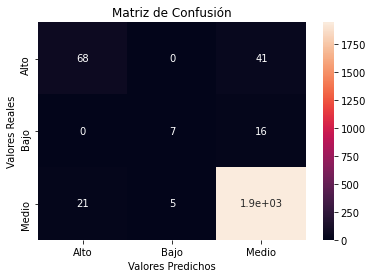

In [11]:
# visualizamos nuestra matriz de confusión

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score

labels = ['Alto', 'Bajo', 'Medio']

cm = confusion_matrix(yTest, predictions_KNN, labels)
fig = plt.figure()
  
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Valores Predichos');ax.set_ylabel('Valores Reales'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Alto', 'Bajo', 'Medio']); ax.yaxis.set_ticklabels(['Alto', 'Bajo', 'Medio']);

# Métricas

validamos el modelo viendo su precission, recall y f1-score for clase. hagamos un repaso rápido a cada métrica utilizando nuestros datos:

**Precisión** correctly predicted / total predicted values

* e.g) precision para calse alta <- 42/56 = 0.75

**Recall** correctly predicted /  total real values

* e.g) precision para calse alta <- 42/56 = 0.75

**Acuracy** sumadiagonal/ total

**Suport** Valores totales de cada clase

**f1-score** media harmónica para medir precisión y recall juntos


In [12]:
print(classification_report(yTest,predictions_KNN))

              precision    recall  f1-score   support

        Alto       0.76      0.62      0.69       109
        Bajo       0.58      0.30      0.40        23
       Medio       0.97      0.99      0.98      1969

    accuracy                           0.96      2101
   macro avg       0.77      0.64      0.69      2101
weighted avg       0.96      0.96      0.96      2101



## Standarizando los datos y aplicando reducción

In [14]:
 # standardize the features
sc = StandardScaler()
# Gerardo - Standard Scaler u=0 sigma=1
samples_train_std_ger = sc.fit_transform(xtrainnum)
samples_test_std_ger = sc.transform(xtestnum)

# PCA
sample_train_pca_ger = pca.fit_transform(samples_train_std_ger)
sample_test_pca_ger = pca.transform(samples_test_std_ger)

print('Porcentaje de la varianza explicada: \t',pca.explained_variance_ratio_)
#print(pca.explained_variance_)
print('Coordenadas de las componentes principales: \n',pca.components_)
print('Autovalores asociados a las componentes: \t',pca.singular_values_)
#print(pca.noise_variance_)

Porcentaje de la varianza explicada: 	 [0.36460361 0.12402938]
Coordenadas de las componentes principales: 
 [[ 0.42433596  0.30676943  0.14888584  0.36631635 -0.00434076  0.03419924
   0.2306335   0.09111849  0.25691688  0.37244665  0.36564519  0.41033502]
 [-0.26479263  0.3199012   0.1815081  -0.04051741 -0.12914568  0.48485305
   0.34227504  0.4369636  -0.38598742 -0.22238282 -0.06440654  0.1747059 ]]
Autovalores asociados a las componentes: 	 [146.41957536  85.39863921]


In [15]:
import warnings
warnings.filterwarnings('ignore')

# Gerardo - KNN
neig_k = np.arange(1, 23, 2)
scores = []
for k in neig_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(sample_train_pca_ger, yTrain)
    predictions_KNN = knn.predict(sample_test_pca_ger)
    scores.append(metrics.accuracy_score(yTest, predictions_KNN))
print('El valor máximo de accuracy se consigue para un k de : ', neig_k[scores.index(max(scores))],
      'con un valor de', max(scores))

print('Valores de accuracy:\n', scores)
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(sample_train_pca_ger, yTrain)
predictions_KNN = knn.predict(sample_test_pca_ger)
# Metricas
print(metrics.accuracy_score(yTest, predictions_KNN))
print(metrics.confusion_matrix(yTest,predictions_KNN))

El valor máximo de accuracy se consigue para un k de :  15 con un valor de 0.9595430747263208
Valores de accuracy:
 [0.9428843407901, 0.9538315088053307, 0.9585911470728224, 0.9566872917658258, 0.9562113279390766, 0.9562113279390766, 0.9590671108995716, 0.9595430747263208, 0.9595430747263208, 0.9576392194193242, 0.9585911470728224]
0.9590671108995716
[[  57    0   52]
 [   0    6   17]
 [  15    2 1952]]


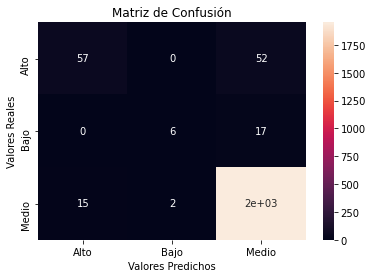

In [16]:
cm2 = confusion_matrix(yTest, predictions_KNN, labels)
fig = plt.figure()
  
ax= plt.subplot()
sns.heatmap(cm2, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Valores Predichos');ax.set_ylabel('Valores Reales'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Alto', 'Bajo', 'Medio']); ax.yaxis.set_ticklabels(['Alto', 'Bajo', 'Medio']);

In [17]:
print(classification_report(yTest,predictions_KNN))

              precision    recall  f1-score   support

        Alto       0.79      0.52      0.63       109
        Bajo       0.75      0.26      0.39        23
       Medio       0.97      0.99      0.98      1969

    accuracy                           0.96      2101
   macro avg       0.84      0.59      0.67      2101
weighted avg       0.95      0.96      0.95      2101



## Normalizando los datos y sin aplicar reducción

In [20]:
# Normalizamos nuestros datos con la función normalize

normalized_xtrain = preprocessing.scale(xtrainnum)
normalizaed_xtest = preprocessing.scale(xtestnum)


In [21]:
#Creamos el clasificador con K = 3 ya que tenemos tres categorías
knn = KNeighborsClassifier(n_neighbors=3)

#Entrenamos el modelo con la funcion fit
knn.fit(normalized_xtrain, yTrain)

#Hacemos las predicciones
y_pred = knn.predict(normalizaed_xtest)

#imprimimos en pantalla nuestro numpy array, previamente transformandolo en un pandas dataframe

df = pd.DataFrame(data=y_pred, columns=["Prediciones"])

print(df.head(10))


  Prediciones
0       Medio
1       Medio
2       Medio
3       Medio
4       Medio
5       Medio
6       Medio
7       Medio
8       Medio
9       Medio


In [22]:
#Importamos el modulo de  scikit-learn metrics module para calcular el accuracy 
#n de correctos dividido entre numero total de predicciones


# Model Accuracy: cuantas veces, en porcentaje, nuestro modelo acierta?
print("Accuracy:",metrics.accuracy_score(yTest, y_pred))

Accuracy: 0.9538315088053307


In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

print(confusion_matrix(yTest,y_pred))

print(classification_report(yTest,y_pred))

[[  56    0   53]
 [   0    1   22]
 [   7    0 1962]]
              precision    recall  f1-score   support

        Alto       0.89      0.51      0.65       109
        Bajo       1.00      0.04      0.08        23
       Medio       0.96      1.00      0.98      1969

    accuracy                           0.96      2101
   macro avg       0.95      0.52      0.57      2101
weighted avg       0.96      0.96      0.95      2101



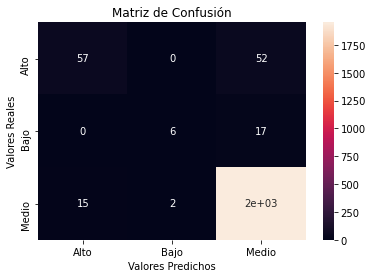

In [26]:
cm3 = confusion_matrix(yTest, predictions_KNN, labels)
fig = plt.figure()
  
ax= plt.subplot()
sns.heatmap(cm3, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Valores Predichos');ax.set_ylabel('Valores Reales'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Alto', 'Bajo', 'Medio']); ax.yaxis.set_ticklabels(['Alto', 'Bajo', 'Medio']);

## Buscando el número óptimo de K

En la prueba inicial, hemos elegido un K=3 ya que nuestra variable target estaba dividida en tres categorías diferentes pero, ¿Es ese número k el más óptimo?

Para probar diferentes versiones, creamos un clasificador automático para determinar el número más óptimo para k en mi modelo KNN. Puedo aplicarle un rango de números, que equivaldrá al número de k que queramos testear. La métrica utilizada de validación sera la misma que antes: su accuracy

[0.9447881960970966, 0.9381247025226083, 0.9538315088053307, 0.9524036173250833, 0.9576392194193242, 0.9609709662065683, 0.9604950023798191, 0.9633507853403142, 0.9600190385530699, 0.9604950023798191, 0.9590671108995716, 0.9604950023798191, 0.9600190385530699, 0.9619228938600667, 0.9595430747263208, 0.9633507853403142, 0.9609709662065683, 0.9609709662065683, 0.9609709662065683]


Text(0, 0.5, 'Testing Accuracy')

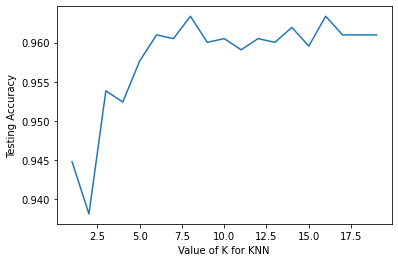

In [23]:
import warnings
warnings.filterwarnings('ignore')

# try K=1 through K=25 and record testing accuracy
k_range = range(1, 20)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(normalized_xtrain, yTrain)
    y_pred = knn.predict(normalizaed_xtest)
    scores.append(metrics.accuracy_score(yTest, y_pred))

print(scores)


# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

